## 1.引言

上一节[带你实现多头注意力](https://golfxiao.blog.csdn.net/article/details/143697790)中我们编写了多头注意力机制，本文将对LLM的其它模块进行编码构建，并最终将它们组装成一个Transformer模块。

下图示意了Transformer的组成部分，包括层归一化、激活函数、前馈神经网络、残差连接，我们将逐一对这些组件进行编码实现。
![transformer组成](./img/8-1.png)


> 本文先不讨论GPT，先讨论Transformer如何构建。
从GPT主干架构开始，看看整体的组成，再来讨论各个核心组件，最终将它们组装到架构中。


## 2.层归一化
层归一化（Layer Normalization）是用来应对训练过程中的梯度消失和梯度爆炸问题，这些问题会导致训练不稳定，使得网络难以有效的调整其权重。
层归一化的主要做法是调整神经网络激活层的输出，使其均值为0，方差为1，以稳定训练过程。它的工作原理如下图所示：

![层归一化](./img/8-2.png)

> 方差概念：一个数据集中每个值与均值之间偏差的平方的平均值被称为`方差`，方差的平方根被称为`标准差`，这两个指标都是用来衡量一个数据集中各个值的离散程度和波动性。

我们将以一个具有5个输入维度、6个输出维度的神经网络层来演示图中的示例，这个神经网络层由一个线性层Linear和一个非线性激活层ReLU组成。

In [3]:
import torch
import torch.nn as nn

torch.manual_seed(123)
batch = torch.randn(2, 5)  # input
print("input:", batch)
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch)
out

input: tensor([[-0.1115,  0.1204, -0.3696, -0.2404, -1.1969],
        [ 0.2093, -0.9724, -0.7550,  0.3239, -0.1085]])


tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)

> Relu是Rectified Linear Unit的缩写，它是神经网络的标准激活函数，它的作用是将负的输入全部设置为0，确保只输出正值，这也是上面的输出结果中没有负值的原因。

计算上面输出结果的均值和方差。

In [11]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
mean, var
# print(f"line 1 mean: {mean[0,0]:.4f}, var: {var[0,0]:.4f}")
# print(f"line 2 mean: {mean[1,0]:.4f}, var: {var[1,0]:.4f}")

(tensor([[0.1324],
         [0.2170]], grad_fn=<MeanBackward1>),
 tensor([[0.0231],
         [0.0398]], grad_fn=<VarBackward0>))

> 注：`dim`参数用于指定按哪个维度来计算均值和方差，-1表示张量的最后一个维度。`keepdim=True`参数可以确保输出张量保持与输入张量相同的形状。如果没有指定此参数，将会由于运算结果变为一维而输出二维向量`[0.1324, 0.2170]`。

mean和var都是2x1的张量，mean中的2个值`0.1324`和`0.2170`分别表示第一行输入和第二行输入的平均值，var也一样。

接下来，对输出进行归一化操作，让每个值减去均值并除以标准差（方差的平方根）。

In [8]:
out_norm = (out - mean)/torch.sqrt(var)
out_norm

tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)

可以看到，归一化后的输出值已经包含了负值。接下来，对归一化后的输出重新计算均值和方差。

In [9]:
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print(f"line 1 mean: {mean[0,0]:.4f}, var: {var[0,0]:.4f}")
print(f"line 2 mean: {mean[1,0]:.4f}, var: {var[1,0]:.4f}")

line 1 mean: 0.0000, var: 1.0000
line 2 mean: 0.0000, var: 1.0000


> 归一化后两行输入的平均值已经为0，方差为1。

将这个过程封装为一个模块，以便能够复用。

In [13]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True)
        x_norm = (x - mean)/(torch.sqrt(var + self.eps))
        return self.scale * x_norm + self.shift

> 注：emb_dim表示嵌入维度，层归一化操作只在输入张量的最后一个维度上运行。eps是添加到方差中的一个小常数，防止在运算过程中除以零。scale和shift是两个可训练的参数，LLM可以在训练期间自动调整这这些参数，以便提高模型在训练任务中的性能。

对封装后的LayerNorm进行功能验证。

In [14]:
ln = LayerNorm(batch.shape[-1])
out_ln = ln(batch)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, keepdim=True)
print(f"line 1 mean: {mean[0,0]:.4f}, var: {var[0,0]:.4f}")
print(f"line 2 mean: {mean[1,0]:.4f}, var: {var[1,0]:.4f}")


line 1 mean: -0.0000, var: 1.0000
line 2 mean: 0.0000, var: 1.0000


## 3.激活函数

上面已经提到，ReLU是神经网络中的标准激活函数，然而在实际的LLM模型中，经常会使用性能更好但相对来说也较为复杂的激活函数GeLU、SwiGLU。

为了进一步理解它们之间的差异，这里以GeLU为例，将ReLU函数与GELU函数的形状并排绘制出来。

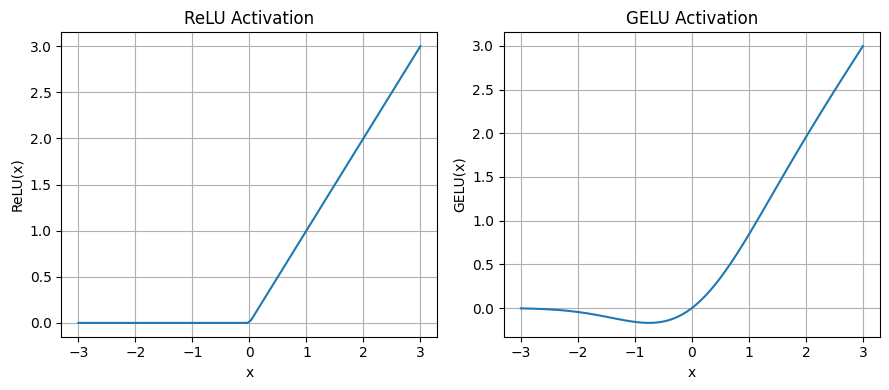

In [39]:
import matplotlib.pyplot as plt

x = torch.linspace(-3, 3, 100)
relu, gelu = nn.ReLU(), nn.GELU()
y_relu, y_gelu = relu(x), gelu(x)
labeled_data = zip(("ReLU", "GELU"), (y_relu, y_gelu))

fig, ax = plt.subplots(1, 2, figsize=(9,4))
for i, (label, y) in enumerate(labeled_data):
    ax[i].plot(x, y)
    ax[i].set_xlabel("x")
    ax[i].set_ylabel(f"{label}(x)")
    ax[i].set_title(f"{label} Activation")
    ax[i].grid(True)

plt.tight_layout()
plt.show()


如上面图所示，ReLU函数对于负数会始终输出0，对于正数会直接输出该输入值。GeLU的输出则相对平滑，并且对于负数的输出不为0。

> GELU 的平滑性在训练过程中可以带来更优的学习性能，相比较之下，ReLU 在零点处有一个尖角，这有时会使优化变得更为困难。此外，GELU 函数对于负值允许有微小的、非零的输出。这一特性允许负输入的神经元仍然可以在一定程度上参与学习过程。

在接下来的Transformer模型中，我们将使用GELU激活函数。

## 4.前馈神经网络

前馈神经网络是由两个线性层和一个GELU激活函数组成的小型神经网络。下图展示了数据输入此网络后，数据的维度是如何进行变换的。

![feedforward](./img/8-3.jpg)

> 如图所示，在经过第一个线性层时，Embedding维度进行了4倍的放大，相当于扩展到了更高的维度空间，后面跟一个非线性的激活函数，再通过第二个线性层将Embedding压缩回原始的维度，这种设计使模型能探索更丰富的表示空间。

接下来，我们会手动创建一个FeedForward模块，代码实现如下所示。

In [63]:
class FeedForward(nn.Module):
    def __init__(self, emb_dim:int):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(emb_dim, 4 * emb_dim),
            nn.GELU(),
            nn.Linear(4 * emb_dim, emb_dim),
        )
    def forward(self, x):
        return self.layers(x)

作为验证，我们初始化一个Embedding大小为768的FeedForward模块，并向其输入包含两个样本的批次数据，每个样本的序列长度为3.

In [64]:
ffn = FeedForward(emb_dim=768)
batch = torch.randn(2, 3, 768)
out = ffn(batch)
out.shape

torch.Size([2, 3, 768])

如上所示，输出张量的形状与输入张量的形状相同。

> 注：输入和输出维度的一致性能够简化架构设计，使得我们可以堆叠多个层，而无需在它们之间调整维度，从而提高了模型的可扩展性。

## 5.残差连接

残差连接，也称为快捷连接，它将层的输入绕过中间运算直接添加到输出结果上，从而创建了一条从输入到输出的快捷路径。下面这张图对不带残差连接（左侧）和带残差连接（右侧）的深度神经网络作了比较。
![残差连接](./img/8-4.jpg)

残差连接主要是为缓解深度网络中的梯度消失问题而提出的，梯度消失是指梯度（用于在训练过程中更新参数）随着深度网络中各层的反向传播而逐渐变小的问题，这使得前面的层训练困难。

下面我们将手动创建一个深度神经网络，并示例如何在前向传播中添加残差连接。


In [57]:
class ExampleDeepNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut=False):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), nn.GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), nn.GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), nn.GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), nn.GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), nn.GELU()),
        ])

    def forward(self, x):
        for layer in self.layers:
            output = layer(x)
            if self.use_shortcut and output.shape == x.shape:
                x = x + output
            else:
                x = output
        return x

> 这段代码实现了一个5层的深度神经网络，每次都由一个Linear和GELU组成，我们在各层之间迭代的传递输入，如果use_shortcut为true，则在每层添加上图所求的快捷方式连接。

下面我们使用此代码先来初始化一个没有残差连接的网络，每层都接受具有3个输入值的示例，最后一层输出一个值。

In [58]:
layer_sizes = [3,3,3,3,3,1]
sample_input = torch.tensor([[1, 0, -1]], dtype=torch.float)
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNetwork(layer_sizes, False)
model_without_shortcut(sample_input)

tensor([[0.0610]], grad_fn=<GeluBackward0>)

接下来，我们将实现一个函数，在模型的反向传播中计算梯度。

In [59]:
def print_gradients(model, x):
    # forward
    output = model(x)
    target = torch.tensor([[0]], dtype=torch.float)
    # loss and backward
    loss_fn = nn.MSELoss()
    loss = loss_fn(output, target)
    loss.backward()
    # print grad
    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f"the mean gradient of {name} is: {param.grad.abs().mean()}")

- `nn.MSELoss()`返回的是损失函数，用于计算预测值output与指定标签值target之间的接近程度（损失）。
- `loss.backward()`是损失的反向传播函数，它会从后往前计算模型中每一层的损失梯度。在我们这个例子中，前4层每层有一个3x3的权重参数矩阵，就有3x3=9个梯度值，我们取这9个梯度的平均值来作为该层的梯度值，用以比较梯度在各层之间反向传播过程中的变化。

先以不带残差连接的模型为例，查看反向传播过程中的梯度变化。

In [60]:
print_gradients(model_without_shortcut, sample_input)

the mean gradient of layers.0.0.weight is: 0.0002017411752603948
the mean gradient of layers.1.0.weight is: 0.00012011770741082728
the mean gradient of layers.2.0.weight is: 0.0007152437465265393
the mean gradient of layers.3.0.weight is: 0.0013988513965159655
the mean gradient of layers.4.0.weight is: 0.005049604922533035


> 可以看到，从最后一层(layer.4)到第0层(layer.0)梯度在逐层减小，梯度值有40多倍的差值，这种现象被称为梯度消失问题。

再以带残差连接的模型为例，查看反向传播过程中的梯度变化。

In [61]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNetwork(layer_sizes, use_shortcut=True)
print_gradients(model_with_shortcut, sample_input)

the mean gradient of layers.0.0.weight is: 0.22186793386936188
the mean gradient of layers.1.0.weight is: 0.20709273219108582
the mean gradient of layers.2.0.weight is: 0.32923877239227295
the mean gradient of layers.3.0.weight is: 0.2667771875858307
the mean gradient of layers.4.0.weight is: 1.3268061876296997


> 只有第4层到第3层有显著的减小，然而第3层到第0层梯度逐渐稳定，并没有缩减到极小的数值，最大值到最小值也只有6倍左右的差值。

## 6. Transformer Block
在这一部分，我们将会结合前面介绍过的多头注意力、层归一化、dropout、前馈层和 GELU 激活函数等概念，来实现一个Transformer块。下图展示了一个transformer块的结构和组成。

![transformer block](./img/8-5.jpg)

> 如上图所示，transformer块的输出是与输入具有相同维度的向量，包括其内部的多头注意力和前馈神经网络，也都在以保持其维度的方式来转换这些向量，这样就可以在后续构建LLM模型时堆叠多个Transformer块。

自注意力机制能够识别并分析输入序列中各元素之间的关系，而前馈网络能够探索更丰富、更抽象的表示空间，这种组合不仅可以更细致的理解和处理输入，还可以增强模型处理复杂数据模式的整体能力。

下面我们将实现一个Transformer块，首先引入之前已经实现自注意力的脚本（多头自注意力已经封装在内）。

In [62]:
%run attention_v1.py

In [67]:
import torch
import torch.nn as nn

class TransformerBlock(nn.Module):
    def __init__(self, cfg: dict):
        super().__init__()
        self.atten = MultiHeadAttention(
            dim_in=cfg['emb_dim'], 
            dim_out=cfg['emb_dim'], 
            context_length=cfg['context_length'], 
            num_heads=cfg['n_heads'], 
            dropout_rate=cfg['drop_rate'],
            qkv_bias=cfg['qkv_bias'])
        self.ffn = FeedForward(cfg['emb_dim'])
        self.drop = nn.Dropout(cfg['drop_rate'])
        self.layernorm1 = LayerNorm(cfg['emb_dim'])
        self.layernorm2 = LayerNorm(cfg['emb_dim'])

    def forward(self, x):
        shortcut = x
        x = self.layernorm1(x)
        x = self.atten(x)
        x = self.drop(x)
        x = x + shortcut

        shortcut = x
        x = self.layernorm2(x)
        x = self.ffn(x)
        x = self.drop(x)
        x = x + shortcut

        return x

上面实现的TransformerBlock类包括两个核心组件MultiHeadAttention和FeedForward，分别在这两个组件之前应用层归一化，这被称为pre-layernorm, 在这两个组件之后应用dropout，以正则化防止过拟合。此外，在这两个组件中都添加了残差连接，输入直接添加到其输出上，这样有助于训练过程中梯度的稳定传播。

> 注：在以前的某些架构中，层归一化是在MultiHeadAttention和FeedForward之后用的，这被称为Post-Layernorm，这种方法在较浅的网络中表现良好，但在更深的网络中会遇到训练不稳定的问题，总体来说，Pre-Layernorm在稳定性方面表现更好。

在这个TransformerBlock类中，入参改用了配置字典(cfg)，这有利于配置的管理和模型结构的扩展。下面是124m参数的GPT2模型配置示例：

In [65]:
MODEL_CONFIG = {
    "vocab_size": 50257, # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768, # Embedding dimension
    "n_heads": 12, # Number of attention heads
    "n_layers": 12, # Number of layers
    "drop_rate": 0.1, # Dropout rate
    "qkv_bias": False # Query-Key-Value bias
}

用这个配置来初始化一个TransformerBlock实例，并给它输入一个批次数据，数据中有两个序列，每个序列有768维。

In [68]:
torch.manual_seed(123)
example_input = torch.randn(2, 4, 768)
block = TransformerBlock(MODEL_CONFIG)
output = block(example_input)
output.shape

torch.Size([2, 4, 768])

从上面输出可以看到，此Transformer块在输出中保持了输入的维度，实际上不仅一个块，Transformer架构在整个神经网络处理数据时都不改变其形状。

**小结**：本节以概念理解+代码演示的方式，逐一介绍了层归一化、激活函数、前馈神经网络和残差连接这几个组件在transformer中的作用，并用这些组件以及上节封装的多头注意力，封装了一个TransformerBlock类，后续章节会用这个类来构建GPT。